In [1]:
import pyro
import pyro.distributions as dst
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.utils import save_image
import torch
import numpy as np
from pyro.infer import SVI, TraceMeanField_ELBO,JitTraceMeanField_ELBO,Trace_ELBO
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
torch.set_default_dtype(torch.float32)
pyro.distributions.enable_validation(False)

In [2]:
class Encoder(nn.Module):
    def __init__(self,sizes):
        super().__init__()
        self.latent_size=sizes[-1]
        self.network=[]
        for i in range(len(sizes)-2):
            self.network.append(nn.Linear(sizes[i],sizes[i+1]))
            self.network.append(nn.LayerNorm(sizes[i+1]))
            self.network.append(nn.ReLU())
            self.network.append(nn.Dropout(p=0.05))
        self.encode_mu=nn.Linear(sizes[-2],sizes[-1])
        self.encode_sigma=nn.Linear(sizes[-2],sizes[-1])
        self.network=nn.Sequential(*self.network)

    def forward(self,x):
        x=self.network(x)
        mu=self.encode_mu(x)
        sigma=torch.exp(self.encode_sigma(x))
        return mu,sigma



class Decoder(nn.Module):
    def __init__(self,sizes):
        super().__init__()
        self.network=[]
        for i in range(len(sizes)-2):
            self.network.append(nn.Linear(sizes[i],sizes[i+1]))
            self.network.append(nn.LayerNorm(sizes[i+1]))
            self.network.append(nn.ReLU())
            self.network.append(nn.Dropout(p=0.05))
        self.network.append(nn.Linear(sizes[-2],sizes[-1]))
        self.network=nn.Sequential(*self.network)
    def forward(self,x):
        return self.network(x)

class TemplateVAE(nn.Module):
    def __init__(self,sizes1,sizes2,device="cpu",ext=False):
        super().__init__()
        assert(sizes1[-1]==sizes2[0])
        self.encoder=Encoder(sizes1).to(device)
        if ext:
            self.decoder=Decoder_Ext(sizes2).to(device)
        else:
            self.decoder=Decoder(sizes2).to(device)
        self.latent_size=sizes2[0]
        self.device=device

    def model(self,data):
        pass

    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder(x)
            # sample the latent code z
            pyro.sample("latent", dst.Normal(z_loc, z_scale).to_event(1))

    def sample(self,data,n_sample):
        samples=torch.zeros(data.shape[0],n_sample,self.latent_size,device=self.device)
        with torch.no_grad():
            mu,sigma=self.encoder(data)
            for i in range(n_sample):
                samples[:,i,:]=mu
        return samples.view(data.shape[0]*n_sample,self.latent_size)

    def kl_loss(self,data):
        with torch.no_grad():
            mu,sigma=self.encoder(data)
            return 0.5*torch.sum(mu.pow(2)+sigma.pow(2)-torch.log(sigma.pow(2))-1)/data.shape[0]   

    def save(self,name="template_VAE.tc"):
        torch.save(self, name)


class GaussianVAE(TemplateVAE):
    def __init__(self,sizes1,sizes2,device="cpu",scale=1):
        super().__init__(sizes1,sizes2,device)
        self.scale=scale
    def model(self,data):
        pyro.module("decoder",self.decoder)
        with pyro.plate("data",data.shape[0]):
            mu = data.new_zeros(torch.Size((data.shape[0], self.latent_size)),device=self.device)
            sigma = data.new_ones(torch.Size((data.shape[0], self.latent_size)),device=self.device)

            z_latent=pyro.sample("latent",dst.Normal(mu,sigma).to_event(1))
            mean=self.decoder(z_latent)
            pyro.sample("obs",dst.Normal(loc=mean,scale=self.scale).to_event(1),obs=data)
    def save(self,name="vanila_VAE.tc"):
        torch.save(self, name)

class BerVAE(TemplateVAE):
    def __init__(self,sizes1,sizes2,device="cpu"):
        super().__init__(sizes1,sizes2,device)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.latent_size)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.latent_size)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dst.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            loc_img = torch.sigmoid(self.decoder(z))
            # score against actual images
            pyro.sample("obs", dst.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))

    def save(self,name="ber_VAE.tc"):
        torch.save(self, name)

def load_mnist(path='mnist.npz'):
    with np.load(path) as f:
        x_train, _y_train = f['x_train'], f['y_train']
        x_test, _y_test = f['x_test'], f['y_test']
        
    x_train = x_train.reshape(-1, 28 * 28) / 255.
    x_test = x_test.reshape(-1, 28 * 28) / 255.
    
    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1
    
    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (torch.tensor(x_train,dtype=torch.float32), torch.tensor(y_train,dtype=torch.float32)), (torch.tensor(x_test,dtype=torch.float32),torch.tensor(y_test,dtype=torch.float32))

In [3]:
(xtrain,ytrain),(xtest,ytest)=load_mnist()
id=np.sum(ytrain.numpy()*np.arange(0,10),axis=1)

In [4]:
num_epoch=50
batch=512
use_gpu=False
if use_gpu:
    VAE=GaussianVAE([784,110,30,10],[10,30,110,784],"cuda")
    device = torch.device("cuda")
    xtrain=xtrain.to(device)
    xtest=xtest.to(device)
else:
    VAE=GaussianVAE([784,110,30,10],[10,30,110,784],device="cpu")

optim=pyro.optim.Adam({"lr":0.003})
err_train=[]
err_test=[]
for a in VAE.encoder.parameters():
    pass
    #print(a)
svi=SVI(VAE.model,VAE.guide,optim,TraceMeanField_ELBO())
for i in range(num_epoch):
    err=0
    for j in range(0,60000,batch):
        xbatch=xtrain[j:j+batch]
        err+=svi.step(xbatch)/len(xtrain)
    print(i,err,svi.evaluate_loss(xtest)/len(xtest))
        

0 752.5690057291666 747.89765
1 747.4035291666672 747.2726
2 747.084003776042 747.03645
3 746.3958401041663 746.12335
4 745.6888929687503 745.4681
5 745.178198046875 745.10065
6 744.9197321614581 744.83975
7 744.5708427083332 744.40555
8 744.0798164062502 744.1316
9 743.6518363281247 743.5088
10 743.2364242187499 743.16375
11 742.9998524739585 742.9894
12 742.8450667968744 742.76315
13 742.6649908854167 742.7084
14 742.5333755208333 742.4896
15 742.3977661458332 742.4021
16 742.2993609374997 742.27245
17 742.2027382812499 742.2257
18 742.129016927083 742.16695
19 742.065111848958 742.0356
20 742.0187356770832 742.07115
21 741.9814140624998 741.98985
22 741.9088576822918 741.96685
23 741.8958298177084 742.0081
24 741.8658135416669 741.90385
25 741.8187205729166 741.8344
26 741.7872162760416 741.83565
27 741.7808990885418 741.83825
28 741.7389761718747 741.77885
29 741.7272395833335 741.7766
30 741.6970744791669 741.7516
31 741.6767852864583 741.73545
32 741.6450436197919 741.7234
33 741

In [5]:
data=VAE.sample(xtrain,1)

In [6]:
pca=PCA().fit(data.cpu().detach().numpy())
values=pca.transform(data.cpu().detach().numpy())[:,:2]

In [7]:
pca.explained_variance_ratio_

array([5.1094550e-01, 4.8845130e-01, 1.7944016e-04, 1.6351130e-04,
       8.9113426e-05, 6.6921202e-05, 3.5208803e-05, 3.0485893e-05,
       2.3700575e-05, 1.4810358e-05], dtype=float32)

In [8]:

values_tsne=TSNE(n_components=2, learning_rate='auto',init='random',perplexity=100).fit_transform(data.cpu().detach().numpy())

<AxesSubplot: >

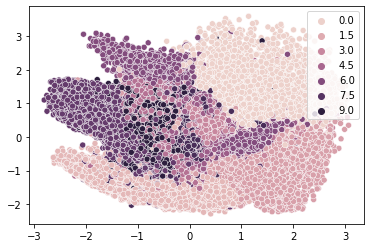

In [9]:
sns.scatterplot(x=values[:,0],y=values[:,1],hue=id)

/home/wesenheit/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot: >

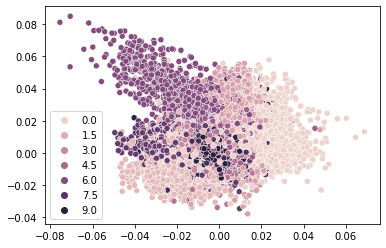

In [10]:
sns.scatterplot(data[:,0],data[:,1],hue=id)

<AxesSubplot: >

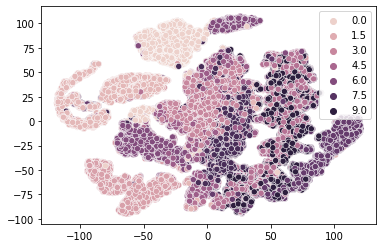

In [11]:
sns.scatterplot(x=values_tsne[:,0],y=values_tsne[:,1],hue=id)